# Scenario E - Peakshape Variation (pVoigt model)

In this scenario the peakshape in a spectrum with a fixed number of peaks is varied from Gaussian (n = 0.0) to Lorentzian (n = 1.0). All datasets contain 3 peaks and the noise level is kept constant at 1%.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_peakshape_pvoigt_lrun'
file_basename = out_path + '/scenario_peakshape_pvoigt'
        
conf = {}
    
# scenario name
conf['scenario'] = 'peakshape variation (pVoigt model)'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors) (normal/lognormal/eta_rv)
conf['prior_model'] = 'eta_rv'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# dataset directory (needed for 'preload' data mode)
#conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'peakshape variation (pVoigt model)',
 'init_mode': 'adapt_diag',
 'prior_model': 'eta_rv',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'generate',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lpeakshape = []

# number of spectra per peakshape factor
nsets  = 40

# peakshape weight factors (0 = Gauss, 1 = Lorentz)
peakshapes = [0.0, 0.25, 0.5, 0.75, 1.0]
lpeakshape = [ps for ps in peakshapes for i in range(nsets)]

# total number of datasets
tsets = nsets * len(peakshapes)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for ps in peakshapes:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, npeaks=3, peakshape=ps)
            ldata.append(df)
            lpeaks.append(peaks)
            
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, _ = dg.data_load(tsets, out_path)

In [7]:
print("total number of peakshape variations    : {0}".format(len(peakshapes)))
print("total number of datasets per peakshape  : {0}".format(nsets))
print("total number of inference runs          : {0}".format(tsets))

total number of peakshape variations    : 5
total number of datasets per peakshape  : 40
total number of inference runs          : 200


In [8]:
# plot datasets
#fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
#                            savefig='yes', fname=file_basename, scenario='peakshape', labels=lpeakshape)

# Initialize models and run inference

In [9]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [10]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if conf['peak_info'] == 'yes':
        plist = lpeaks[i].flatten()
        plist.sort()
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3,
                              mu_peaks=plist, pmodel=conf['prior_model'])
    else:
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3,
                                              pmodel=conf['prior_model'])
                
    models.append(model_g)

    with model_g:
        print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
        trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
        traces.append(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #1/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1,103 divergences: 100%|██████████| 5000/5000 [04:39<00:00, 17.90draws/s] 
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8927329600195669, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1099 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.14660747760238063, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #2/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 296.43draws/s]
The acceptance probability does not match the target. It is 0.8830340651938204, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #3/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 264 divergences: 100%|██████████| 5000/5000 [02:21<00:00, 35.39draws/s] 
There were 253 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9467727251155978, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #4/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [03:15<00:00, 25.64draws/s]
The acceptance probability does not match the target. It is 0.9146475822370017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8968049434904345, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #5/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:01<00:00, 80.74draws/s] 
The acceptance probability does not match the target. It is 0.8851664545560761, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #6/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 359.38draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8821103095315848, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #7/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:23<00:00, 59.56draws/s]
The acceptance probability does not match the target. It is 0.8913167524837037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884806136717449, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #8/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 284.86draws/s]
The acceptance probability does not match the target. It is 0.8960608203561294, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #9/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 337.37draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8965807698651866, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #10/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:50<00:00, 45.18draws/s]
The acceptance probability does not match the target. It is 0.8930377013740113, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928059884043364, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #11/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 306.92draws/s]
The acceptance probability does not match the target. It is 0.9233559901488017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9117777572426046, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #12/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 343.94draws/s]
The acceptance probability does not match the target. It is 0.9060739581861622, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9038844341173675, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #13/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 374.63draws/s]
The acceptance probability does not match the target. It is 0.8813742006473019, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #14/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:47<00:00, 106.22draws/s]
The acceptance probability does not match the target. It is 0.9265011844806079, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9060654336151895, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #15/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:21<00:00, 237.36draws/s]
The acceptance probability does not match the target. It is 0.8870737533156734, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #16/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 304.63draws/s]
The acceptance probability does not match the target. It is 0.9140143591190993, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8945977339926243, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #17/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:23<00:00, 214.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #18/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 300.73draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8849287281073452, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #19/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:15<00:00, 66.28draws/s]
The acceptance probability does not match the target. It is 0.9285317836990815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.927575602773247, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #20/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 391.52draws/s]
The acceptance probability does not match the target. It is 0.8787478223249059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972567957775076, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #21/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 289.47draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8995848177610699, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #22/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 329.95draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786684552636375, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8785973953933308, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #23/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 325.68draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9107461579201342, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #24/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:40<00:00, 124.37draws/s]
The acceptance probability does not match the target. It is 0.9080141972417635, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9197605777546187, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #25/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 264.09draws/s]
The acceptance probability does not match the target. It is 0.890722882965776, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9287308109272961, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #26/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1,784 divergences: 100%|██████████| 5000/5000 [09:30<00:00,  8.77draws/s] 
There were 566 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11997187979375351, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #27/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 299.16draws/s]
The acceptance probability does not match the target. It is 0.8843985783988856, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #28/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 303.75draws/s]
The acceptance probability does not match the target. It is 0.9035077845889158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9237411474848133, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #29/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 292.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #30/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 276.37draws/s]
The acceptance probability does not match the target. It is 0.9128568880512388, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048127651251956, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #31/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 272.87draws/s]
The acceptance probability does not match the target. It is 0.8890593303955625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9470154214970424, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #32/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 377.43draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #33/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:43<00:00, 115.24draws/s]
The acceptance probability does not match the target. It is 0.8900100539663346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9112354659728913, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #34/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:08<00:00, 72.91draws/s] 
The acceptance probability does not match the target. It is 0.926316899984219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9269773349490611, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #35/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 329.35draws/s]
The acceptance probability does not match the target. It is 0.8881443587735237, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948151291634379, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #36/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 304.61draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9282922376050096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9218861250085649, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #37/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 334.14draws/s]
The acceptance probability does not match the target. It is 0.8937366942376194, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #38/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 255.17draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8849056008437812, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8899479963190396, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #39/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 349.96draws/s]
The acceptance probability does not match the target. It is 0.885879572104709, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8947830507344408, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #40/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 332.29draws/s]
The acceptance probability does not match the target. It is 0.8976786444039528, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #41/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 352.40draws/s]
The acceptance probability does not match the target. It is 0.9218316352419864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880658279944743, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #42/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 9 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 303.09draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8842789975695984, but should be close to 0.8. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #43/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 383.32draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9055885141393415, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #44/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 314.18draws/s]
The acceptance probability does not match the target. It is 0.8968108528045439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #45/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:03<00:00, 78.90draws/s] 
The acceptance probability does not match the target. It is 0.8961487123309684, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #46/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 339.65draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8900836079240778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9212192411170469, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #47/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 362.15draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #48/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 296.37draws/s]
The acceptance probability does not match the target. It is 0.8801128309874077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9250583262768373, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #49/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 330.55draws/s]
The acceptance probability does not match the target. It is 0.9048640911400689, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #50/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 307.38draws/s]
The acceptance probability does not match the target. It is 0.9269874908356572, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8789835802280822, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #51/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 275.59draws/s]
The acceptance probability does not match the target. It is 0.9083029395811129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9314872095906629, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #52/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:35<00:00, 141.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #53/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 427.23draws/s]
The acceptance probability does not match the target. It is 0.8837320469671186, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #54/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 307.36draws/s]
The acceptance probability does not match the target. It is 0.8817467609684407, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #55/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 365.35draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #56/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 265.74draws/s]
The acceptance probability does not match the target. It is 0.9199853772652338, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #57/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 423.86draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8878282662971598, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #58/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [07:15<00:00, 11.49draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #59/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 299.58draws/s]
The acceptance probability does not match the target. It is 0.8815968605102051, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #60/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 368.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #61/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 346.23draws/s]
The acceptance probability does not match the target. It is 0.9027667917544347, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #62/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 343.26draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.902280945092122, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #63/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 325.60draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9127256607555094, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #64/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 332.92draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #65/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 351.16draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8859670370843189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786334522959386, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #66/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 358.20draws/s]
The acceptance probability does not match the target. It is 0.8792174956211046, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #67/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 323.34draws/s]
The acceptance probability does not match the target. It is 0.889027810770012, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #68/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 297.82draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #69/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 292.99draws/s]
The acceptance probability does not match the target. It is 0.9196284126219345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9172794894132145, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #70/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:22<00:00, 225.41draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #71/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 562 divergences: 100%|██████████| 5000/5000 [11:03<00:00,  7.54draws/s]
There were 562 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #72/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:55<00:00, 90.56draws/s] 
The acceptance probability does not match the target. It is 0.8942955514126811, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #73/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 373.63draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8983034581046081, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9034358884517542, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #74/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 322.72draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8855426782786705, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8838724847945515, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #75/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:16<00:00, 65.69draws/s]
The acceptance probability does not match the target. It is 0.9165240879857168, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.918052251361099, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #76/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:11<00:00, 69.99draws/s]
The acceptance probability does not match the target. It is 0.9213768521513092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9102576159841208, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #77/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 309.77draws/s]
The acceptance probability does not match the target. It is 0.8812598228601439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9072023910518741, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #78/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:49<00:00, 45.56draws/s]
The acceptance probability does not match the target. It is 0.9208897038690471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151155789167638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #79/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 372.40draws/s]
The acceptance probability does not match the target. It is 0.9083062952100442, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #80/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 374.02draws/s]
The acceptance probability does not match the target. It is 0.8912535799893636, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #81/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 338.14draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.892351976477941, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8917966058605056, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #82/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 312.12draws/s]
The acceptance probability does not match the target. It is 0.905980320333332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9105716171745332, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #83/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 336.47draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8810729989244128, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #84/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 303.49draws/s]
The acceptance probability does not match the target. It is 0.8851475296212822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895403348284845, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #85/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 343.82draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #86/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:26<00:00, 189.08draws/s]
The acceptance probability does not match the target. It is 0.9198027681416724, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902866681722701, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #87/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:32<00:00, 152.63draws/s]
The acceptance probability does not match the target. It is 0.8983054232984802, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #88/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 328.25draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8975962044251167, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #89/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 318.49draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.883090890316903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9113997527875022, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #90/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 333.19draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8837019204244726, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #91/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 338.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #92/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 278.54draws/s]
The acceptance probability does not match the target. It is 0.8940335587632672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945664990382431, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #93/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 353.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #94/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:16<00:00, 65.40draws/s]
The acceptance probability does not match the target. It is 0.9301826701827143, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9265505898868028, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #95/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 332.69draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9003576247050801, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #96/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 428.82draws/s]
The acceptance probability does not match the target. It is 0.8853382599381717, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #97/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:33<00:00, 147.15draws/s]
The acceptance probability does not match the target. It is 0.94147607099763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9112537152266788, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #98/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 340.37draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9044152610892455, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9112405419301178, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #99/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 358.10draws/s]
The acceptance probability does not match the target. It is 0.8886679602616255, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #100/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 372.07draws/s]
The acceptance probability does not match the target. It is 0.889698093083486, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #101/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:42<00:00, 30.80draws/s]
The acceptance probability does not match the target. It is 0.906328996224528, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928364114022136, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #102/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 294.79draws/s]
The acceptance probability does not match the target. It is 0.8855295017285688, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #103/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 286.00draws/s]
The acceptance probability does not match the target. It is 0.9026846640092069, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #104/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:23<00:00, 60.11draws/s]
The acceptance probability does not match the target. It is 0.9048906417685081, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9192855007480214, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #105/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 350.22draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8801139884649963, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #106/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 330.72draws/s]
The acceptance probability does not match the target. It is 0.8926064108334391, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8854823369959381, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #107/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [09:06<00:00,  9.15draws/s]
The acceptance probability does not match the target. It is 0.8959373427074176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9146198700375832, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #108/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 365.03draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #109/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 323.97draws/s]
The acceptance probability does not match the target. It is 0.8824372797717727, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #110/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:41<00:00, 49.50draws/s]
The acceptance probability does not match the target. It is 0.9043717507406891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9206253494542194, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #111/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 347.50draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8870709742463089, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974605115480878, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #112/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 247.91draws/s]
The acceptance probability does not match the target. It is 0.8813352034859033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892843043171128, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #113/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 361.06draws/s]
The acceptance probability does not match the target. It is 0.8900624582504307, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #114/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 14 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 327.21draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #115/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:35<00:00, 52.35draws/s]
The acceptance probability does not match the target. It is 0.9209818093177861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9121713085145213, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #116/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 251.16draws/s]
The acceptance probability does not match the target. It is 0.8866347597972123, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #117/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:19<00:00, 19.26draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #118/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 306.57draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9053576789496115, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #119/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:02<00:00, 40.90draws/s]
The acceptance probability does not match the target. It is 0.892286731346212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #120/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 281.44draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9052737304138307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9129183945435783, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #121/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 304.77draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9024188707549018, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #122/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 241.57draws/s]
The acceptance probability does not match the target. It is 0.9132933966985343, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #123/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:27<00:00, 184.39draws/s]
The acceptance probability does not match the target. It is 0.910820113795349, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #124/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 300.29draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9014368206958762, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048132518803544, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #125/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 316.74draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #126/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 308.08draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8990744586114653, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8795941079654146, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #127/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 402.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #128/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 284.62draws/s]
The acceptance probability does not match the target. It is 0.9316876021170912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057412192528002, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #129/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 273.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #130/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 327.35draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9013768453097246, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #131/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 314.06draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8984588248476657, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #132/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:23<00:00, 59.96draws/s] 
The acceptance probability does not match the target. It is 0.9502690491478305, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9419150512361328, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #133/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 294.89draws/s]
The acceptance probability does not match the target. It is 0.8966266172415688, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8858914335356622, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #134/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 323.17draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #135/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:29<00:00, 170.13draws/s]
The acceptance probability does not match the target. It is 0.912853761783035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9233943852849893, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #136/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:24<00:00, 202.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #137/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 308.58draws/s]
The acceptance probability does not match the target. It is 0.906697325408416, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #138/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 362.60draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #139/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 313.22draws/s]
The acceptance probability does not match the target. It is 0.8879097636286111, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #140/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 349.36draws/s]
The acceptance probability does not match the target. It is 0.8799998358193328, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8915334893328068, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #141/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 293.00draws/s]
The acceptance probability does not match the target. It is 0.9210861466315817, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9153361468850035, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #142/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:22<00:00, 60.68draws/s]
The acceptance probability does not match the target. It is 0.886333932090938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013230825039105, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #143/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 282.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #144/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 308.19draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8967853424794386, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893893915694931, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #145/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:35<00:00, 138.91draws/s]
The acceptance probability does not match the target. It is 0.9193156560238918, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.929397996017128, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #146/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 7 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 320.39draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8882580254383657, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #147/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 287.11draws/s]
The acceptance probability does not match the target. It is 0.9288744913071959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018366276245502, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #148/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 290.50draws/s]
The acceptance probability does not match the target. It is 0.8933745945117315, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #149/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 359.05draws/s]
The acceptance probability does not match the target. It is 0.9009414387800809, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #150/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:21<00:00, 238.06draws/s]
The acceptance probability does not match the target. It is 0.9155252106385586, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #151/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 371.84draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8788991474731648, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #152/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 412 divergences: 100%|██████████| 5000/5000 [11:58<00:00,  6.96draws/s]
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #153/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:14<00:00, 66.88draws/s]
The acceptance probability does not match the target. It is 0.8825459708072733, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #154/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 314.58draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.88180847777591, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8786757442678826, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #155/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:58<00:00, 16.72draws/s]
The acceptance probability does not match the target. It is 0.8788438429296676, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #156/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 372.16draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #157/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 334.87draws/s]
The acceptance probability does not match the target. It is 0.8978411538863468, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #158/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 293.18draws/s]
The acceptance probability does not match the target. It is 0.8801297461946759, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #159/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 335.90draws/s]
The acceptance probability does not match the target. It is 0.8869283244487525, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #160/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 10 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 313.12draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #161/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 288.83draws/s]
The acceptance probability does not match the target. It is 0.9072539197607151, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8904338688555716, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #162/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 256.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8863590063994359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292274264794845, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #163/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [02:42<00:00, 30.80draws/s]
The acceptance probability does not match the target. It is 0.8885730344528914, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #164/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 287.61draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8883749424836914, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #165/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:05<00:00, 76.77draws/s] 
The acceptance probability does not match the target. It is 0.8804985045144194, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842727295491616, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #166/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 383 divergences: 100%|██████████| 5000/5000 [07:33<00:00, 11.02draws/s]
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8993048998496574, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #167/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 250.79draws/s]
The acceptance probability does not match the target. It is 0.911721639758885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952867961730262, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #168/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:42<00:00, 118.46draws/s]
The acceptance probability does not match the target. It is 0.9245447772757946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9274611256194342, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #169/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 285.57draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8855239571924804, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9076455836389139, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #170/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 277.53draws/s]
The acceptance probability does not match the target. It is 0.9110430526867018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952379756234794, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #171/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 260.65draws/s]
The acceptance probability does not match the target. It is 0.9057831662924745, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #172/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 266.49draws/s]
The acceptance probability does not match the target. It is 0.9186303144326324, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #173/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 318.72draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #174/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 327.46draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #175/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:29<00:00, 171.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #176/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 255.21draws/s]
The acceptance probability does not match the target. It is 0.9124736020792579, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933650587101032, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #177/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 297.07draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #178/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 294.14draws/s]
The acceptance probability does not match the target. It is 0.900221330912337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9090364496389596, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #179/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 394.10draws/s]
The acceptance probability does not match the target. It is 0.8831178797929493, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #180/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 254.85draws/s]
The acceptance probability does not match the target. It is 0.9165109475887279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9280059448001553, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #181/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 321.37draws/s]
The acceptance probability does not match the target. It is 0.9134254936098093, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #182/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 708 divergences: 100%|██████████| 5000/5000 [07:07<00:00, 11.70draws/s]
There were 252 divergences after tuning. Increase `target_accept` or reparameterize.
There were 455 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #183/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:42<00:00, 116.76draws/s]
The acceptance probability does not match the target. It is 0.902940329287356, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9198762792706904, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #184/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 257.08draws/s]
The acceptance probability does not match the target. It is 0.9203566101281095, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #185/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:33<00:00, 149.41draws/s]
The acceptance probability does not match the target. It is 0.9219692294807719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9428872105216761, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #186/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 239.33draws/s]
The acceptance probability does not match the target. It is 0.8828089088323141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993909052990293, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #187/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 289.60draws/s]
The acceptance probability does not match the target. It is 0.9059460444629779, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8936003502583425, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #188/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 316.26draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8790888947849795, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #189/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:02<00:00, 79.60draws/s] 
The acceptance probability does not match the target. It is 0.9244236961795598, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9359625080458963, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #190/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 250.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #191/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 313.39draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8824111708383487, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8917845089636105, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #192/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 262.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #193/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [05:23<00:00, 15.45draws/s]
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #194/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 243.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #195/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 687 divergences: 100%|██████████| 5000/5000 [10:19<00:00,  8.07draws/s]
There were 269 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 418 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #196/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:33<00:00, 148.66draws/s]
The acceptance probability does not match the target. It is 0.910354254780228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888483621577531, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #197/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [11:15<00:00,  7.40draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #198/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 338.27draws/s]
The acceptance probability does not match the target. It is 0.8827983607932077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799947693236253, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #199/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 276.01draws/s]
The acceptance probability does not match the target. It is 0.9107423788825374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9088659670560796, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #200/200


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, eta, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 267.02draws/s]
The acceptance probability does not match the target. It is 0.8889635193942335, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9064607276190642, but should be close to 0.8. Try to increase the number of tuning steps.


# Model visualization

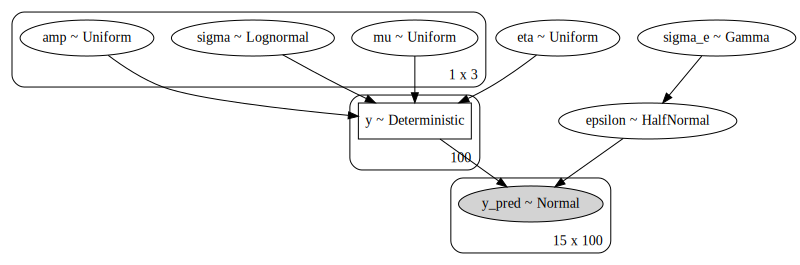

In [11]:
# display first model
pm.model_to_graphviz(models[0])

In [12]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [13]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 482.51it/s]
/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 501.92it/s]


100%|██████████| 500/500 [00:00<00:00, 504.35it/s]


In [14]:
# collect the results and display
varnames = mdl.get_varnames(traces[0])
df = res.get_results_summary(traces, ppc, y_val, varnames, epsilon_real=0.05, eta_real=lpeakshape)
df

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real,eta,eta_real
1,1.780909,0.226636,104.363636,1.249257,0.999856,-4675.470979,0.049972,0.05,0.005661,0.0
2,1.000000,0.000000,4383.363636,1.029887,0.999035,-2331.742859,0.109758,0.05,0.000332,0.0
3,1.070909,0.049455,684.363636,1.014762,0.999820,-4207.406117,0.059134,0.05,0.000384,0.0
4,1.005455,0.003818,1720.727273,1.037991,0.999818,-4715.487126,0.050034,0.05,0.008271,0.0
5,1.000000,0.000727,2124.454545,1.044191,0.999872,-4726.544298,0.049924,0.05,0.001852,0.0
...,...,...,...,...,...,...,...,...,...,...
196,1.000000,0.000182,2297.909091,1.000964,0.999846,-4766.885947,0.049235,0.05,0.998066,1.0
197,1.450909,0.557818,1605.181818,1.008004,0.999950,-4836.525261,0.048113,0.05,0.999041,1.0
198,1.000000,0.000000,4905.090909,1.054635,0.999424,-2786.356407,0.094399,0.05,0.977116,1.0
199,1.000000,0.000000,3922.636364,0.997197,0.999916,-4743.426499,0.049649,0.05,0.999503,1.0


In [15]:
# save results to .csv
df.to_csv(file_basename + '.csv', index=False)

In [16]:
cnf.close(out_path)